# Initialization

In [1]:
%load_ext autoreload
%load_ext line_profiler
import sys
sys.path.append("..")

In [2]:
%autoreload

import numpy as np
import pickle

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import main

import darkhistory.physics as phys
import darkhistory.utilities as utils

from darkhistory.spec import spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from darkhistory.low_energy import lowE_electrons
from darkhistory.low_energy import lowE_deposition

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm


In [3]:

direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/'

direc_arr = [direc, direc]
xes = np.array([
    0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]),
    None]
)
string_arr = ["_xHe0", "_standard_xe_xHe_full_rs"]


(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc_arr, xes, string_arr=string_arr, inverted=True)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Done.



In [4]:
highengphot_tf_interp

In [5]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

Load the standard ionization and thermal histories.

In [6]:
soln = pickle.load(open("/Users/hongwan/Github/DarkHistory/darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
Tm_std = interp1d(soln[0,:], soln[1,:])

# Choice of Mass Parameter and Channel

In [24]:
# mDM = 4e12
mDM = 4e5
# mDM = 6e6

# chan = 'phot'
chan = 'phot'

rerun = True
sandbox = True

# Load Reference Files

## Load Reference Spectra

Load the file containing the reference spectra.

In [8]:
if mDM == 4e12:

    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_1.230E+01_xe_0.000E+00.fits'
    )

elif mDM == 4e5:
    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_5.301E+00_xe_0.000E+00.fits'
    )
    
elif mDM == 6e6:
    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_6.477E+00_xe_0.000E+00.fits'
    )

else:
    raise TypeError('invalid mDM.')
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]
idl_hionfraction = data.field('hionfraction')[0]
idl_heionfraction = data.field('heionfraction')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

hdul.close()

In [9]:
10**6.477

2999162.5189876533

## Load Reference $f(z)$ (Direct from IDL)

Load the file containing the $f(z)$ calculations

In [10]:
if mDM == 4e12:

    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'calculated_fractions_'+chan+'_logE_1.230E+01.fits'
    )
    
elif mDM == 4e5:
    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'calculated_fractions_'+chan+'_logE_5.301E+00.fits'
    )
    
elif mDM == 6e6:
    hdul = fits.open(
        '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/'
        +'calculated_fractions_'+chan+'_logE_6.477E+00.fits'
    )

else:
    raise TypeError('invalid mDM.')

data = hdul[1].data

f_idl_low  = data.field('loweng_deposition_fractions')[0]
f_idl_high = data.field('higheng_deposition_fractions')[0]
xe_idl     = data.field('xH')[0]


f_idl = f_idl_low + f_idl_high


hdul.close()

## Load Reference $f(z)$ (from Mathematica)

Load the $f(z)$ values from Mathematica.

In [11]:
direc = '/Users/hongwan/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

In [12]:
log10f_tmp = log10f_phot_decay

def f_H_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_He_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['He_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_H_exc(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_exc'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_heating(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['heating'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_cont(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['cont'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

# `DarkHistory` Evaluation

In [27]:
%autoreload

eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

tau = 0.5e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

# find the uppermost bin to perform the injection.
# inject mDM/2/eng_delta_inj particles.

if chan == 'phot':
    
    injE = photeng[photeng < mDM/2][-1]

    phot_spec_init = spectools.rebin_N_arr(np.array([2*mDM/2/injE]), np.array([injE]), photeng)
    phot_spec_init.rs = 3000

    elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)
    
elif chan == 'elec':
    
    injE = eleceng[eleceng < (mDM - 2*phys.me)/2][-1]
    
    elec_spec_init = spectools.rebin_N_arr(
        np.array([2*(mDM - 2*phys.me)/2/injE]), 
        np.array([injE]), 
        eleceng
    )
    elec_spec_init.rs = 3000

    phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

# Evolve according to xe provided by the IDL file.

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))

if mDM == 4e12:
    text_mDM = '4e12'
elif mDM == 4e5:
    text_mDM = '4e5'
elif mDM == 6e6:
    text_mDM = '6e6'
else:
    raise TypeError('Invalid mDM.')
raw_file_text = 'mDM_'+text_mDM+'_'+chan


try:
    if rerun:
        raise
    b = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/"+raw_file_text+".raw", "rb"))
except: 
    b = main.evolve(
        elec_spec_init, phot_spec_init, rate_func_N, rate_func_eng, 4, 
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
        highengdep_interp, CMB_engloss_interp, 
        ics_only=False, separate_higheng=True, 
        ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, 
        engloss_ref_tf=engloss_ref_tf, 
        coarsen_factor=1,std_soln=True, xH_func=xe_idl_func, user=None, verbose=False, use_tqdm=True
    )
    if not sandbox:
        pickle.dump(b, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/final_darkhistory_comparison/"+raw_file_text+".raw", "wb"))
    




## Timing Example

In [ ]:
# %autoreload

# %lprun -f main.evolve main.evolve(elec_spec_init, phot_spec_init, rate_func_N, rate_func_eng, 2600, highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, highengdep_interp, CMB_engloss_interp, ics_only=False, separate_higheng=True, ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf, coarsen_factor=1,std_soln=True, xH_func=xe_idl_func, user=None, verbose=False, use_tqdm=True)

# from main import evolve



# $f(z)$ Calculation Comparisons - PASSED

## `DarkHistory` Calculation

First, we will compare the $f(z)$ computed by `DarkHistory` with the values obtained by Tracy, using the same spectral input from the IDL produced reference file, but running `lowE_deposition.compute_fs` to obtain the corresponding values of $f(z)$. 

We can call MEDEA_interp with either two 1D interpolations, or one 2D interpolation, but the actual result changes very little.

In [ ]:
# Create the MEDEA interpolation object. Default is 2D
MEDEA_interp = lowE_electrons.make_interpolator()

In [ ]:
# Vector of dt steps.
rs_vec = b[3].rs
dt_vec = 0.001/phys.hubble(rs_vec)

# Choose the xe to use: from xe_std, or from the IDL file.
# std_xe_vec = xe_std(rs_vec)
std_xe_vec = xe_idl

# Store x_input in the correct format
x_input = np.transpose([1-std_xe_vec, np.zeros_like(std_xe_vec), np.zeros_like(std_xe_vec)])

# Calculate rate_input for input to compute_fs
rate_input = rate_func_eng(rs_vec)

# Convert the IDL spectra to Spectra objects.
ref_lowengelec = Spectra(idl_lowengelec*idl_elec_bin_width, eng=idl_eleceng, rs=rs_vec, spec_type='N')
ref_lowengphot = Spectra(idl_lowengphot*idl_bin_width, eng=idl_energy, rs=rs_vec, spec_type='N')

# Empty container for f's
f_arr_DH_low = np.outer(np.zeros_like(rs_vec),np.zeros(5))
f_arr_DH_high = np.outer(np.zeros_like(rs_vec),np.zeros(5))

# Loop compute_fs over the spectra produced.
for i, (elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss) in tqdm(
    enumerate(
        zip(
            ref_lowengelec, ref_lowengphot, x_input, rate_input, dt_vec, 
            np.transpose(idl_highengdep), idl_cmblosstable
        )
    ),   
    total = idl_cmblosstable.shape[0] # Just for tqdm
) :
    f = lowE_deposition.compute_fs(
        MEDEA_interp, elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss, method="old", 
        separate_higheng=True
    )
    f_arr_DH_low[i]  += f[0]
    f_arr_DH_high[i] += f[1]
                 

## $f(z)$ Plots - Absolute Comparison

In [ ]:
plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift (1+z)')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec, f_arr_DH_low[:,i], label='IDL spectra, DH compute\_fs, Low')
    plt.plot(rs_vec, f_idl_low[i,:], label='IDL spectra, IDL newfracs.pro, Low')
    plt.plot(rs_vec, f_arr_DH_high[:,i], label='IDL spectra, DH compute\_fs, High')
    plt.plot(rs_vec, f_idl_high[i,:], label='IDL spectra, IDL newfracs.pro, High')
    plt.legend()

## $f(z)$ Plots - Relative Comparison

In [ ]:
plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift (1+z)')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
        
    plt.axis([1, 3000, 0.5, 2])
    plt.plot(rs_vec, f_arr_DH_low[:,i]/f_idl_low[i,:], label='Ratio DH/IDL, low')
    plt.plot(rs_vec, f_arr_DH_high[:,i]/f_idl_high[i,:], label='Ratio DH/IDL, high')
    
    plt.legend()

## Comments

To get agreement, two important things must be done. 

* The photon deposition method must be in agreement with the IDL method, which does not sum over partial bins. 
* The ionization history must be identical. 

Without these two points, there are large deviations at the start (excitation can be as much as 20% larger) as well as during recombination.

# `main.evolve` Tests

## Spectrum Absolute Comparison

2970.1495012475025


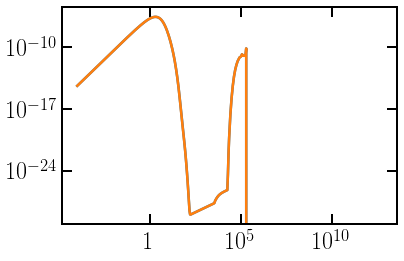

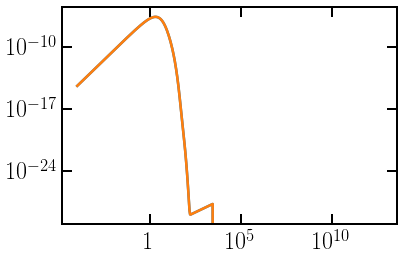

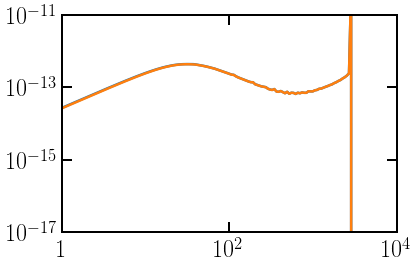

In [29]:
i = 10
print(idl_redshift[i])

plt.figure()
ax = plt.gca()
# ax.set_xscale('log')
ax.loglog()

# plt.axis([1e-4, 5e12, 1e-40, 5e-6])

photeng = idl_energy

plt.plot(photeng, b[2].grid_vals[i])
plt.plot(photeng, idl_photonspectrum[i]*idl_bin_width)

# np.set_printoptions(threshold=np.nan)
# utils.compare_arr([photeng, b[2][i].N, idl_photonspectrum[i]*idl_bin_width])

plt.figure()
ax = plt.gca()
# ax.set_xscale('log')
ax.loglog()

# # plt.axis([1e2, 4e3, 0, 0.5e-28])
# photeng = idl_energy

plt.plot(photeng, b[3].grid_vals[i])
plt.plot(photeng, idl_lowengphot[i]*idl_bin_width)



plt.figure()
ax = plt.gca()
ax.loglog()
# ax.set_xscale('log')

# plt.axis([1e-4, 5e12, 1e-40, 1e-10])

eleceng = idl_eleceng
plt.axis([1, 1e4, 1e-17, 1e-11])
plt.plot(eleceng, b[4].grid_vals[i])
plt.plot(eleceng, idl_lowengelec[i]*idl_elec_bin_width)

# plt.figure()
# ax = plt.gca()
# # ax.loglog()
# ax.set_xscale('log')


# # plt.axis([1e3, 3e3, 1e-16, 5e-15])
# plt.plot(idl_redshift, b[5])
# plt.plot(idl_redshift, idl_cmblosstable)

# plt.figure()
# ax = plt.gca()

# ax.set_xscale('log')

# plt.plot(idl_redshift, b[5]/idl_cmblosstable)

## Spectrum Relative Comparison

2994.005996001995
1.0


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


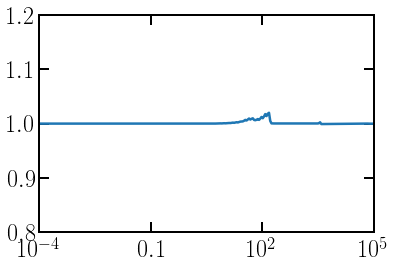

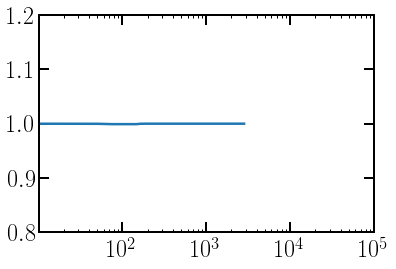

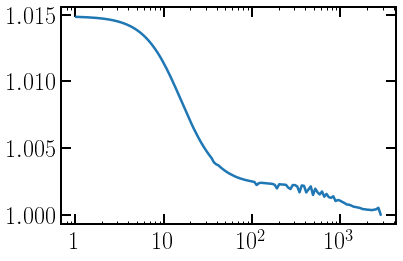

In [30]:
i = 2
print(idl_redshift[i])
print(xe_idl_func(idl_redshift[i]))

plt.figure()
ax = plt.gca()
ax.set_xscale('log')

photeng = idl_energy

plt.axis([1e-4, 1e5, 0.8, 1.2])

plt.plot(photeng, b[2].grid_vals[i]/(idl_photonspectrum[i]*idl_bin_width))

plt.figure()
ax = plt.gca()
ax.set_xscale('log')


# plt.axis([1e1, 130, 0, 0.5e-30])
photeng = idl_energy

plt.axis([10.2, 1e5, 0.8, 1.2])


plt.plot(photeng, b[3].grid_vals[i]/(idl_lowengphot[i]*idl_bin_width))



plt.figure()
ax = plt.gca()
ax.set_xscale('log')

# # plt.axis([1e-4, 5e12, 1e-40, 1e-10])

eleceng = idl_eleceng
# plt.axis([1, 1e4, 1e-12, 4e-8])
plt.plot(eleceng, b[4].grid_vals[i]/(idl_lowengelec[i]*idl_elec_bin_width))

# plt.figure()
# ax = plt.gca()
# # ax.loglog()
# ax.set_xscale('log')


# # plt.axis([1e3, 3e3, 1e-16, 5e-15])
# plt.plot(idl_redshift, b[5])
# plt.plot(idl_redshift, idl_cmblosstable)

# plt.figure()
# ax = plt.gca()

# ax.set_xscale('log')

# plt.plot(idl_redshift, b[5]/idl_cmblosstable)

## $f(z)$ Plots - Absolute Comparison

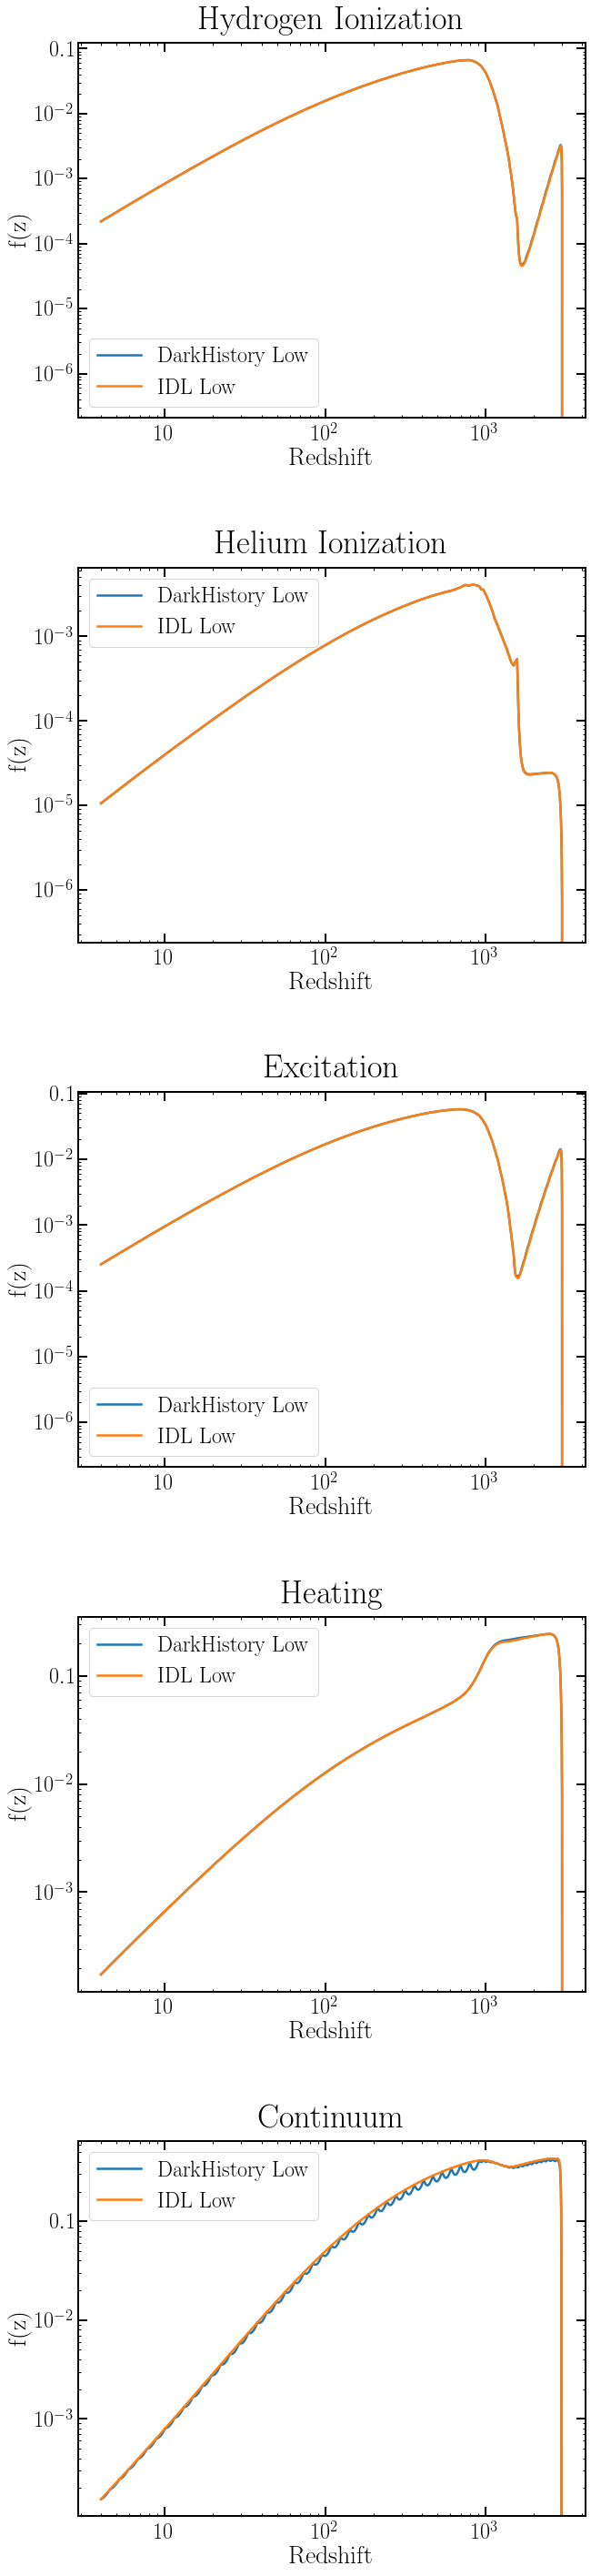

In [31]:
injE = photeng[photeng < mDM/2][-1]
    
rs_vec = idl_redshift

f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec_math = np.vstack([
    f_H_ion_vec_math, f_He_ion_vec_math, 
    f_exc_vec_math, f_heat_vec_math, 
    f_cont_vec_math
])


plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
#     plt.axis([1000, 3000, 1e-7, .3])
    plt.plot(rs_vec[1:], b[6][0][:,i], label='DarkHistory Low')
#     plt.plot(rs_vec[1:], b[6][1][:,i], label='DarkHistory High')
#     plt.plot(rs_vec[1:], f_vec_math[i], label='Mathematica')
#     plt.plot(rs_vec, f_idl[i], label='IDL')
    plt.plot(rs_vec, f_idl_low[i], label='IDL Low')
#     plt.plot(rs_vec, f_idl_high[i], label='IDL High')
    
    plt.legend()


## $f(z)$ Plots - Relative Comparison

In [ ]:
injE = photeng[photeng < mDM/2][-1]
    

f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec_math = np.vstack([
    f_H_ion_vec_math, f_He_ion_vec_math, 
    f_exc_vec_math, f_heat_vec_math, 
    f_cont_vec_math
])


plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

if mDM == 4e12:
    mDM_text = '4e12 eV'
elif mDM == 4e5:
    mDM_text = '4e5 eV'
elif mDM == 6e6:
    mDM_text = '6e6 eV'
else:
    raise TypeError('invalid mDM.')

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization, '+mDM_text+', '+chan)
    elif i == 1:
        plt.title('Helium Ionization, '+mDM_text+', '+chan)
    elif i == 2:
        plt.title('Excitation, '+mDM_text+', '+chan)
    elif i == 3:
        plt.title('Heating, '+mDM_text+', '+chan)
    elif i == 4:
        plt.title('Continuum, '+mDM_text+', '+chan)
        
#     plt.axis([4, 3000, 0.5, 1.3])
    plt.plot(rs_vec[1:],b[6][0][:,i]/f_idl_low[i,:-1], label='DH/IDL, Low')
    if i != 4:
        plt.plot(rs_vec[1:],b[6][1][:,i]/f_idl_high[i,:-1], label='DH/IDL, High')
    ax.axhline(0.95, color='gray', linestyle=':')
    ax.axhline(1.05, color='gray', linestyle=':')
    
    
    plt.legend()


Difficulty with interpolation for 400 keV DM mass to photons: there is a sharp increase corresponding to a CMB bump from ICS, difficult to interpolate.